In [ ]:
# Import libraries
#!pip install opencv-python
import os,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import backend as K
K.set_image_data_format('channels_last')
from keras.layers import Concatenate
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
import glob
from google.colab import drive
import os


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/drive/MyDrive/Publication_Dataset-20220804T163854Z-001.zip
  inflating: Publication_Dataset/AMD8/019.tif  
  inflating: Publication_Dataset/AMD8/031.tif  
  inflating: Publication_Dataset/AMD13/033.tif  
  inflating: Publication_Dataset/AMD8/011.tif  
  inflating: Publication_Dataset/AMD13/034.tif  
  inflating: Publication_Dataset/AMD8/025.tif  
  inflating: Publication_Dataset/AMD13/029.tif  
  inflating: Publication_Dataset/AMD8/022.tif  
  inflating: Publication_Dataset/AMD8/037.tif  
  inflating: Publication_Dataset/AMD8/018.tif  
  inflating: Publication_Dataset/AMD8/029.tif  
  inflating: Publication_Dataset/AMD13/036.tif  
  inflating: Publication_Dataset/AMD8/020.tif  
  inflating: Publication_Dataset/AMD13/035.tif  
  inflating: Publication_Dataset/AMD8/023.tif  
  inflating: Publication_Dataset/AMD13/031.tif  
  inflating: Publ

# Data Reading and Labeling

In [ ]:
PATH = os.getcwd()
# Define data path
drive.mount('/content/drive/')
!unzip /content/drive/MyDrive/Publication_Dataset-20220804T163854Z-001.zip
data_path = '/content/Publication_Dataset'
 
data_dir_list = os.listdir(data_path)

img_rows=128
img_cols=128
num_channel=1
num_epoch=2
no_images=0

for dataset in data_dir_list:
    img_list = os.listdir(data_path + '/' + dataset)
    no_images = no_images+len(img_list)

# Define the number of classes
labels = np.ones((no_images,),dtype='int64')
num_classes = 3
label_index=0
img_data_list=[]
img=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img)
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        if dataset[0]==  'A':
            labels[label_index]=  0
            #print(dataset[0])
        if dataset[0] == 'D':
            labels[label_index] = 1
            #print(dataset[0])
        if dataset[0] == 'N':
            labels[label_index] = 2
        label_index = label_index+1
            #print(dataset[0])


Loaded the images of dataset-NORMAL7

Loaded the images of dataset-AMD4

Loaded the images of dataset-NORMAL5

Loaded the images of dataset-DME9

Loaded the images of dataset-NORMAL8

Loaded the images of dataset-AMD2

Loaded the images of dataset-DME7

Loaded the images of dataset-AMD1

Loaded the images of dataset-AMD13

Loaded the images of dataset-AMD7

Loaded the images of dataset-AMD14

Loaded the images of dataset-NORMAL3

Loaded the images of dataset-DME8

Loaded the images of dataset-DME5

Loaded the images of dataset-DME12

Loaded the images of dataset-NORMAL9

Loaded the images of dataset-DME3

Loaded the images of dataset-DME2

Loaded the images of dataset-NORMAL6

Loaded the images of dataset-DME15

Loaded the images of dataset-AMD10

Loaded the images of dataset-NORMAL2

Loaded the images of dataset-AMD12

Loaded the images of dataset-AMD9

Loaded the images of dataset-AMD15

Loaded the images of dataset-DME13

Loaded the images of dataset-NORMAL12

Loaded the images of d

# Preprocessing steps

In [ ]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)


# Using 'th' for the image_dim_ordering we get accuracy >=0.99 . 
# Using 'tf' for the dim order I get accuracy >= 0.9 but on more epochs
if num_channel==1:
    if K.image_data_format=='channels_first':
        img_data= np.expand_dims(img_data, axis=1)
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=3)
        print (img_data.shape)

else:
    if K.image_data_format=='channels_last':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)


        #labels[0:722] = 0
        #labels[723:1823] = 1
        #labels[1824:3231] = 2
        
        
        #X_train.shape
        

'''        
USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
    # using sklearn for preprocessing
    from sklearn import preprocessing

    def image_to_feature_vector(image, size=(128, 128)):
        # resize the image to a fixed size, then flatten the image into
        # a list of raw pixel intensities
        return cv2.resize(image, size).flatten()

    img_data_list=[]
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_flatten=image_to_feature_vector(input_img,(128,128))
            img_data_list.append(input_img_flatten)

    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data_scaled = preprocessing.scale(img_data)
    print (img_data_scaled.shape)

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)


    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

if USE_SKLEARN_PREPROCESSING:
    img_data=img_data_scaled
    
    #%%
labels[0:1000]
#%%

'''

(3231, 128, 128)
(3231, 128, 128, 1)


"        \nUSE_SKLEARN_PREPROCESSING=False\n\nif USE_SKLEARN_PREPROCESSING:\n    # using sklearn for preprocessing\n    from sklearn import preprocessing\n\n    def image_to_feature_vector(image, size=(128, 128)):\n        # resize the image to a fixed size, then flatten the image into\n        # a list of raw pixel intensities\n        return cv2.resize(image, size).flatten()\n\n    img_data_list=[]\n    for dataset in data_dir_list:\n        img_list=os.listdir(data_path+'/'+ dataset)\n        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))\n        for img in img_list:\n            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )\n            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)\n            input_img_flatten=image_to_feature_vector(input_img,(128,128))\n            img_data_list.append(input_img_flatten)\n\n    img_data = np.array(img_data_list)\n    img_data = img_data.astype('float32')\n    print (img_data.shape)\n    img_data_scaled = pr

In [ ]:
K.image_data_format()


'channels_last'

In [ ]:
from sklearn.utils import shuffle
# Assigning Labels

# Define the number of classes
num_classes = 3

names = ['AMD','DME','NORMAL']

# convert class labels to on-hot encoding
y = np_utils.to_categorical(labels, num_classes)
X=img_data
#Shuffle the dataset with random state=2
X, y = shuffle(X, y, random_state=2)

# Split the dataset with 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2,test_size=0.2)


# Define the model 

In [ ]:
# Defining the model 
# Feel free to use CNNs/Dense Networks

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 1)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.5))


model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


# Viewing model_configuration
model.summary()
#model.get_config()
#model.layers[0].get_config()
#model.layers[0].input_shape
#model.layers[0].output_shape
#model.layers[0].output
#model.layers[0].get_weights()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [ ]:
# Train and fit wit appropiate batch size, epochs, verbose = 1 and validation set
hist = None
learning_rate = 0.001
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train,batch_size=24,verbose=1, epochs=20, validation_data=(X_test, y_test))

# model saving 
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# Save the model in hdf5 file
model.save("my_model")

# Load the saved model
loaded_model=load_model("my_model")

Epoch 1/20
108/108 [==============================] - 5s 42ms/step - loss: 4.6823e-04 - accuracy: 1.0000 - val_loss: 2.4317e-05 - val_accuracy: 1.0000
Epoch 2/20
108/108 [==============================] - 4s 37ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.0072 - val_accuracy: 0.9969
Epoch 3/20
108/108 [==============================] - 4s 38ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 2.7150e-05 - val_accuracy: 1.0000
Epoch 4/20
108/108 [==============================] - 4s 38ms/step - loss: 0.0027 - accuracy: 0.9985 - val_loss: 2.1851e-06 - val_accuracy: 1.0000
Epoch 5/20
108/108 [==============================] - 4s 38ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0059 - val_accuracy: 0.9969
Epoch 6/20
108/108 [==============================] - 4s 38ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 7.5014e-05 - val_accuracy: 1.0000
Epoch 7/20
108/108 [==============================] - 4s 38ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 4.8837e-0

In [ ]:
# Evaluate the model w.r.t Test Loss and Test Accuracy
score = score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 0s 18ms/step - loss: 7.5203e-04 - accuracy: 1.0000
Test Loss: 0.0007520319195464253
Test accuracy: 1.0


[[6.423e-16 1.000e+00 1.788e-19]
 [2.807e-20 1.000e+00 5.684e-16]
 [8.894e-25 1.000e+00 9.633e-27]
 [1.000e+00 5.552e-14 6.648e-15]
 [1.000e+00 2.207e-26 2.874e-25]
 [0.000e+00 0.000e+00 1.000e+00]
 [8.921e-32 2.180e-31 1.000e+00]
 [1.000e+00 1.396e-17 1.957e-20]
 [0.000e+00 0.000e+00 1.000e+00]
 [0.000e+00 1.399e-36 1.000e+00]]
[1 1 1 0 0 2 2 0 2 2]
Confusion matrix, without normalization
[[3 0 0]
 [0 3 0]
 [0 0 4]]


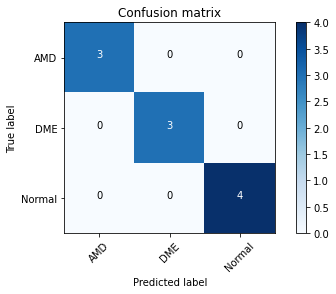

In [ ]:
# Predict model on Test Data

prediction = model.predict(X_test[:10])
print(prediction)

# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Print the classes of the Prediction
classes=np.argmax(prediction,axis=1)
print(classes)

target_names = ['AMD', 'DME', 'Normal']
                                        
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Computation  confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(prediction,axis=1), classes))

np.set_printoptions(precision=3)

plt.figure()

# Plotting non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix')
plt.show()